In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import logging
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

In [33]:
df = pd.read_csv("/content/cleaned_bank.csv")
logger.info(f"Loaded cleaned data: {df.shape}")
df.head()

,job,education,default,housing,loan,day_of_week,month,y,dummy_telephone,dummy_nonexistent,dummy_success,marital_ordinal,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,896,10679,0,0,0,2,5,0,1,1,0,1,1.694589,0.386969,-0.813041,-0.160978,-0.35466,0.660475,0.741141,0.89177,0.720656,0.339946
1,3452,8281,-1,0,0,2,5,0,1,1,0,1,1.797914,-0.412615,-0.813041,-0.160978,-0.35466,0.660475,0.741141,0.89177,0.720656,0.339946
2,3452,8281,0,1,0,2,5,0,1,1,0,1,-0.268597,0.137099,-0.813041,-0.160978,-0.35466,0.660475,0.741141,0.89177,0.720656,0.339946
3,9107,10679,0,0,0,2,5,0,1,1,0,1,0.041380,-0.398337,-0.813041,-0.160978,-0.35466,0.660475,0.741141,0.89177,0.720656,0.339946
4,3452,8281,0,0,1,2,5,0,1,1,0,1,1.694589,0.715370,-0.813041,-0.160978,-0.35466,0.660475,0.741141,0.89177,0.720656,0.339946


In [34]:
print(df['y'].value_counts(normalize=True))

y
0    0.919122
1    0.080878
Name: proportion, dtype: float64


In [35]:
df['month'].value_counts()

,count
month,
5,12159
7,5881
8,5317
6,4507
11,3707
4,2306
10,594
3,467
9,459


In [36]:
# Cell 3: Prepare Time-Series (Fixed for Numeric 'month')
print("Debug: df['month'] type:", df['month'].dtype)
print("Debug: df['month'] unique:", df['month'].unique()[:10])

# Check if 'month' is numeric (1-12); skip mapping if yes
if df['month'].dtype in ['int64', 'float64']:
    df['month_num'] = df['month'].astype(int)  # Already numeric
    logger.info("'month' is numeric - skipping string mapping")
else:
    # String case (fallback)
    month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    df['month'] = df['month'].str.lower().str.strip()
    df['month_num'] = df['month'].map(month_map)
    df['month_num'].fillna(df['month_num'].mode()[0], inplace=True)

print("Debug: month_num unique:", df['month_num'].unique()[:10])
print("Debug: month_num null count:", df['month_num'].isnull().sum())

# Create 'ds' (2017 assumption; use month_num directly)
df['ds'] = pd.to_datetime('2017-' + df['month_num'].astype(str).str.zfill(2) + '-01')
print("Debug: ds sample:", df['ds'].head())
print("Debug: y sum per ds sample:", df.groupby('ds')['y'].sum().head(10))

# Aggregate (ensure 'ds' is sorted)
ts = df.groupby('ds')['y'].sum().reset_index()
ts.columns = ['ds', 'y']
ts['ds'] = pd.to_datetime(ts['ds'])
ts = ts.sort_values('ds').reset_index(drop=True)  # Sort to avoid empty
logger.info(f"Time-series shape: {ts.shape}")
print(ts.head(10))

if ts.empty:
    raise ValueError("TS still empty - verify df has 'y' > 0 and valid 'month_num'")

Debug: df['month'] type: int64
Debug: df['month'] unique: [ 5  6  7  8 10 11 12  3  4  9]
Debug: month_num unique: [ 5  6  7  8 10 11 12  3  4  9]
Debug: month_num null count: 0
Debug: ds sample: 0   2017-05-01
1   2017-05-01
2   2017-05-01
3   2017-05-01
4   2017-05-01
Name: ds, dtype: datetime64[ns]
Debug: y sum per ds sample: ds
2017-03-01    237
2017-04-01    383
2017-05-01    414
2017-06-01    364
2017-07-01    292
2017-08-01    406
2017-09-01    199
2017-10-01    258
2017-11-01    257
2017-12-01     64
Name: y, dtype: int64
          ds    y
0 2017-03-01  237
1 2017-04-01  383
2 2017-05-01  414
3 2017-06-01  364
4 2017-07-01  292
5 2017-08-01  406
6 2017-09-01  199
7 2017-10-01  258
8 2017-11-01  257
9 2017-12-01   64


In [37]:
split_date = ts['ds'].max() - pd.DateOffset(months=3)
train = ts[ts['ds'] < split_date]
test = ts[ts['ds'] >= split_date]
logger.info(f"Train: {len(train)} periods, Test: {len(test)} periods")
print(f"Split date: {split_date}")

Split date: 2017-09-01 00:00:00


In [50]:
from prophet import Prophet
m = Prophet(
    changepoint_prior_scale=0.05,  # Tune for flexibility on trends
    seasonality_mode='additive'    # Additive for subscriptions (non-multiplicative)
)
m.fit(train)
logger.info("Prophet model fitted")

future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)
logger.info("Forecast generated")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx8ppksjt/1cxcrphg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx8ppksjt/lwo2suat.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59875', 'data', 'file=/tmp/tmpx8ppksjt/1cxcrphg.json', 'init=/tmp/tmpx8ppksjt/lwo2suat.json', 'output', 'file=/tmp/tmpx8ppksjt/prophet_modelk04d1u1v/prophet_model-20250916182911.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:29:11 - cmdstanpy - INFO - Chain [1] start processing
IN

<Figure size 1200x600 with 0 Axes>

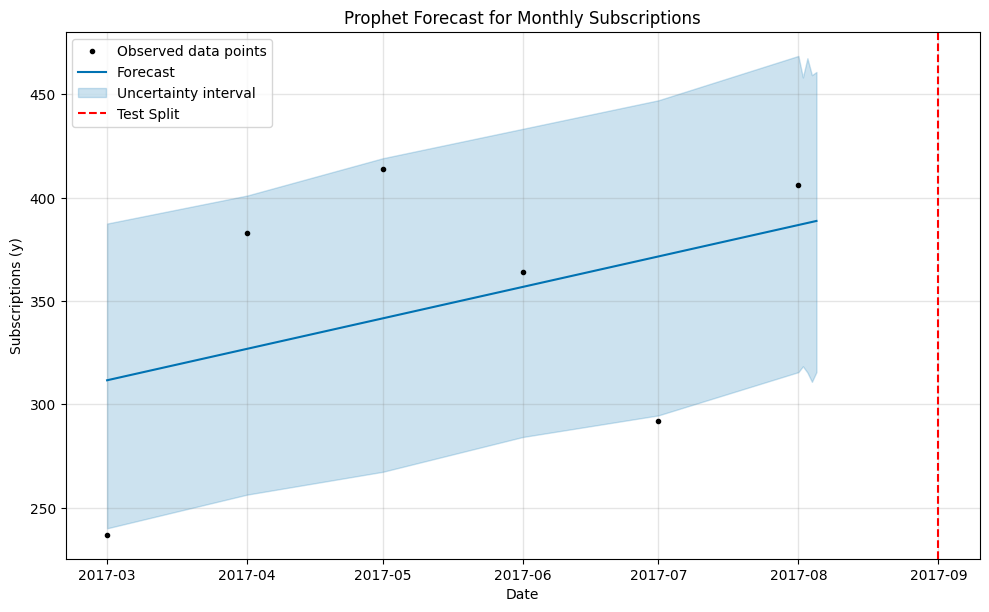

In [51]:
plt.figure(figsize=(12, 6))
m.plot(forecast)
plt.axvline(split_date, color='red', linestyle='--', label='Test Split')
plt.title('Prophet Forecast for Monthly Subscriptions')
plt.xlabel('Date')
plt.ylabel('Subscriptions (y)')
plt.legend()
plt.show()

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_pred = forecast['yhat'].tail(len(test)).values
y_actual = test['y'].values
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f"MAE on Test: {mae:.2f}")
print(f"RMSE on Test: {rmse:.2f}")

MAE on Test: 193.52
RMSE on Test: 209.16


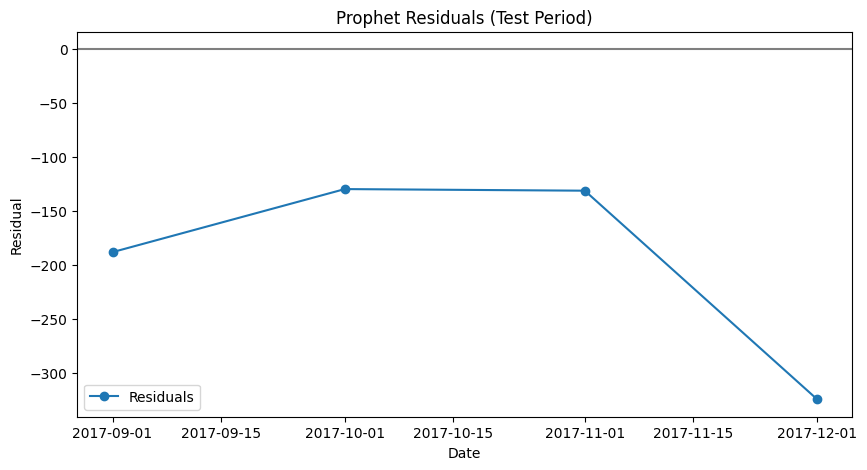

In [54]:
# Residual plot
plt.figure(figsize=(10, 5))
plt.plot(test['ds'], y_actual - y_pred, label='Residuals', marker='o')
plt.axhline(0, color='black', linestyle='-', alpha=0.5)
plt.title('Prophet Residuals (Test Period)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.show()
logger.info(f"Evaluation complete: MAE={mae:.2f}, RMSE={rmse:.2f}")

In [55]:
future_trend = forecast['yhat'].tail(4).mean()  # Next 4 months avg
train_mean = train['y'].mean()
test_mean = test['y'].mean()

if future_trend > test_mean:
    insight = "Rising trend in subscriptions → Recommend scaling campaigns (e.g., increase budget 20% in high-engagement months)."
elif future_trend < train_mean:
    insight = "Declining/volatile trend → Optimize: Focus on top audiences from EDA (e.g., management jobs) and reduce low-duration campaigns."
else:
    insight = "Stable trend → Maintain current allocation, test A/B on channels like 'cellular'."

print(f"Strategy Insight: {insight}")
print(f"Future avg forecast: {future_trend:.0f} vs. Test mean: {test_mean:.0f}")

Strategy Insight: Rising trend in subscriptions → Recommend scaling campaigns (e.g., increase budget 20% in high-engagement months).
Future avg forecast: 388 vs. Test mean: 194


In [56]:
future_trend = forecast['yhat'].tail(4).mean()
if future_trend > train['y'].mean():
    print("Trend: Increasing subscriptions → Recommend scaling campaigns.")
else:
    print("Trend: Stable/declining → Focus on high-value audiences.")

Trend: Increasing subscriptions → Recommend scaling campaigns.


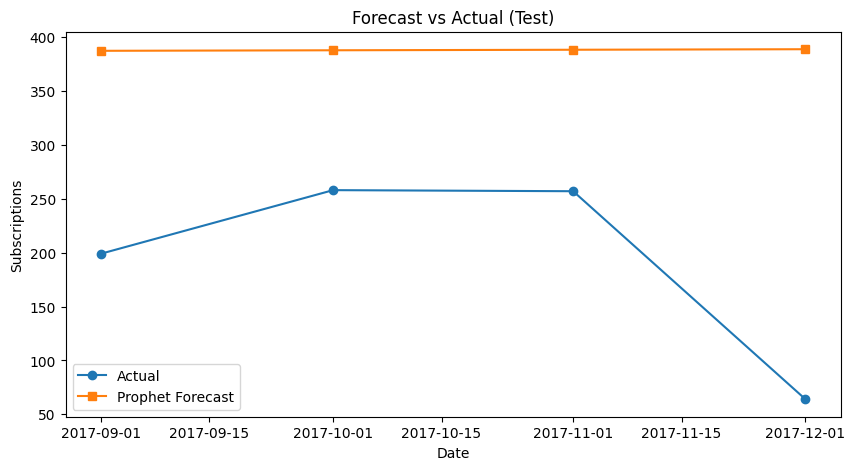

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(test['ds'], test['y'], label='Actual', marker='o')
plt.plot(test['ds'], y_pred, label='Prophet Forecast', marker='s')
plt.title('Forecast vs Actual (Test)')
plt.xlabel('Date')
plt.ylabel('Subscriptions')
plt.legend()
plt.show()

In [61]:
# Save processed TS for project use
ts.to_csv('bank_ts.csv', index=False)
forecast.to_csv('bank_forecast.csv', index=False)
logger.info("Forecast experiment complete - TS and forecast saved")